In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import pandas as pd
import random
import itertools
import seaborn as sns

sns.set(style = 'darkgrid')
% matplotlib inline


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
bc = pd.read_csv('data.csv')
bc.head(1)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,NaN


scale the data to chart it and allow better predictive power

In [4]:
bcs = pd.DataFrame(preprocessing.scale(bc.iloc[:,2:32]))
bcs.columns = list(bc.iloc[:,2:32].columns)
bcs['diagnosis'] = bc['diagnosis']


check for correlation between variables and diagnosis

C:\Users\Admin\Anaconda3\New folder (2)\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


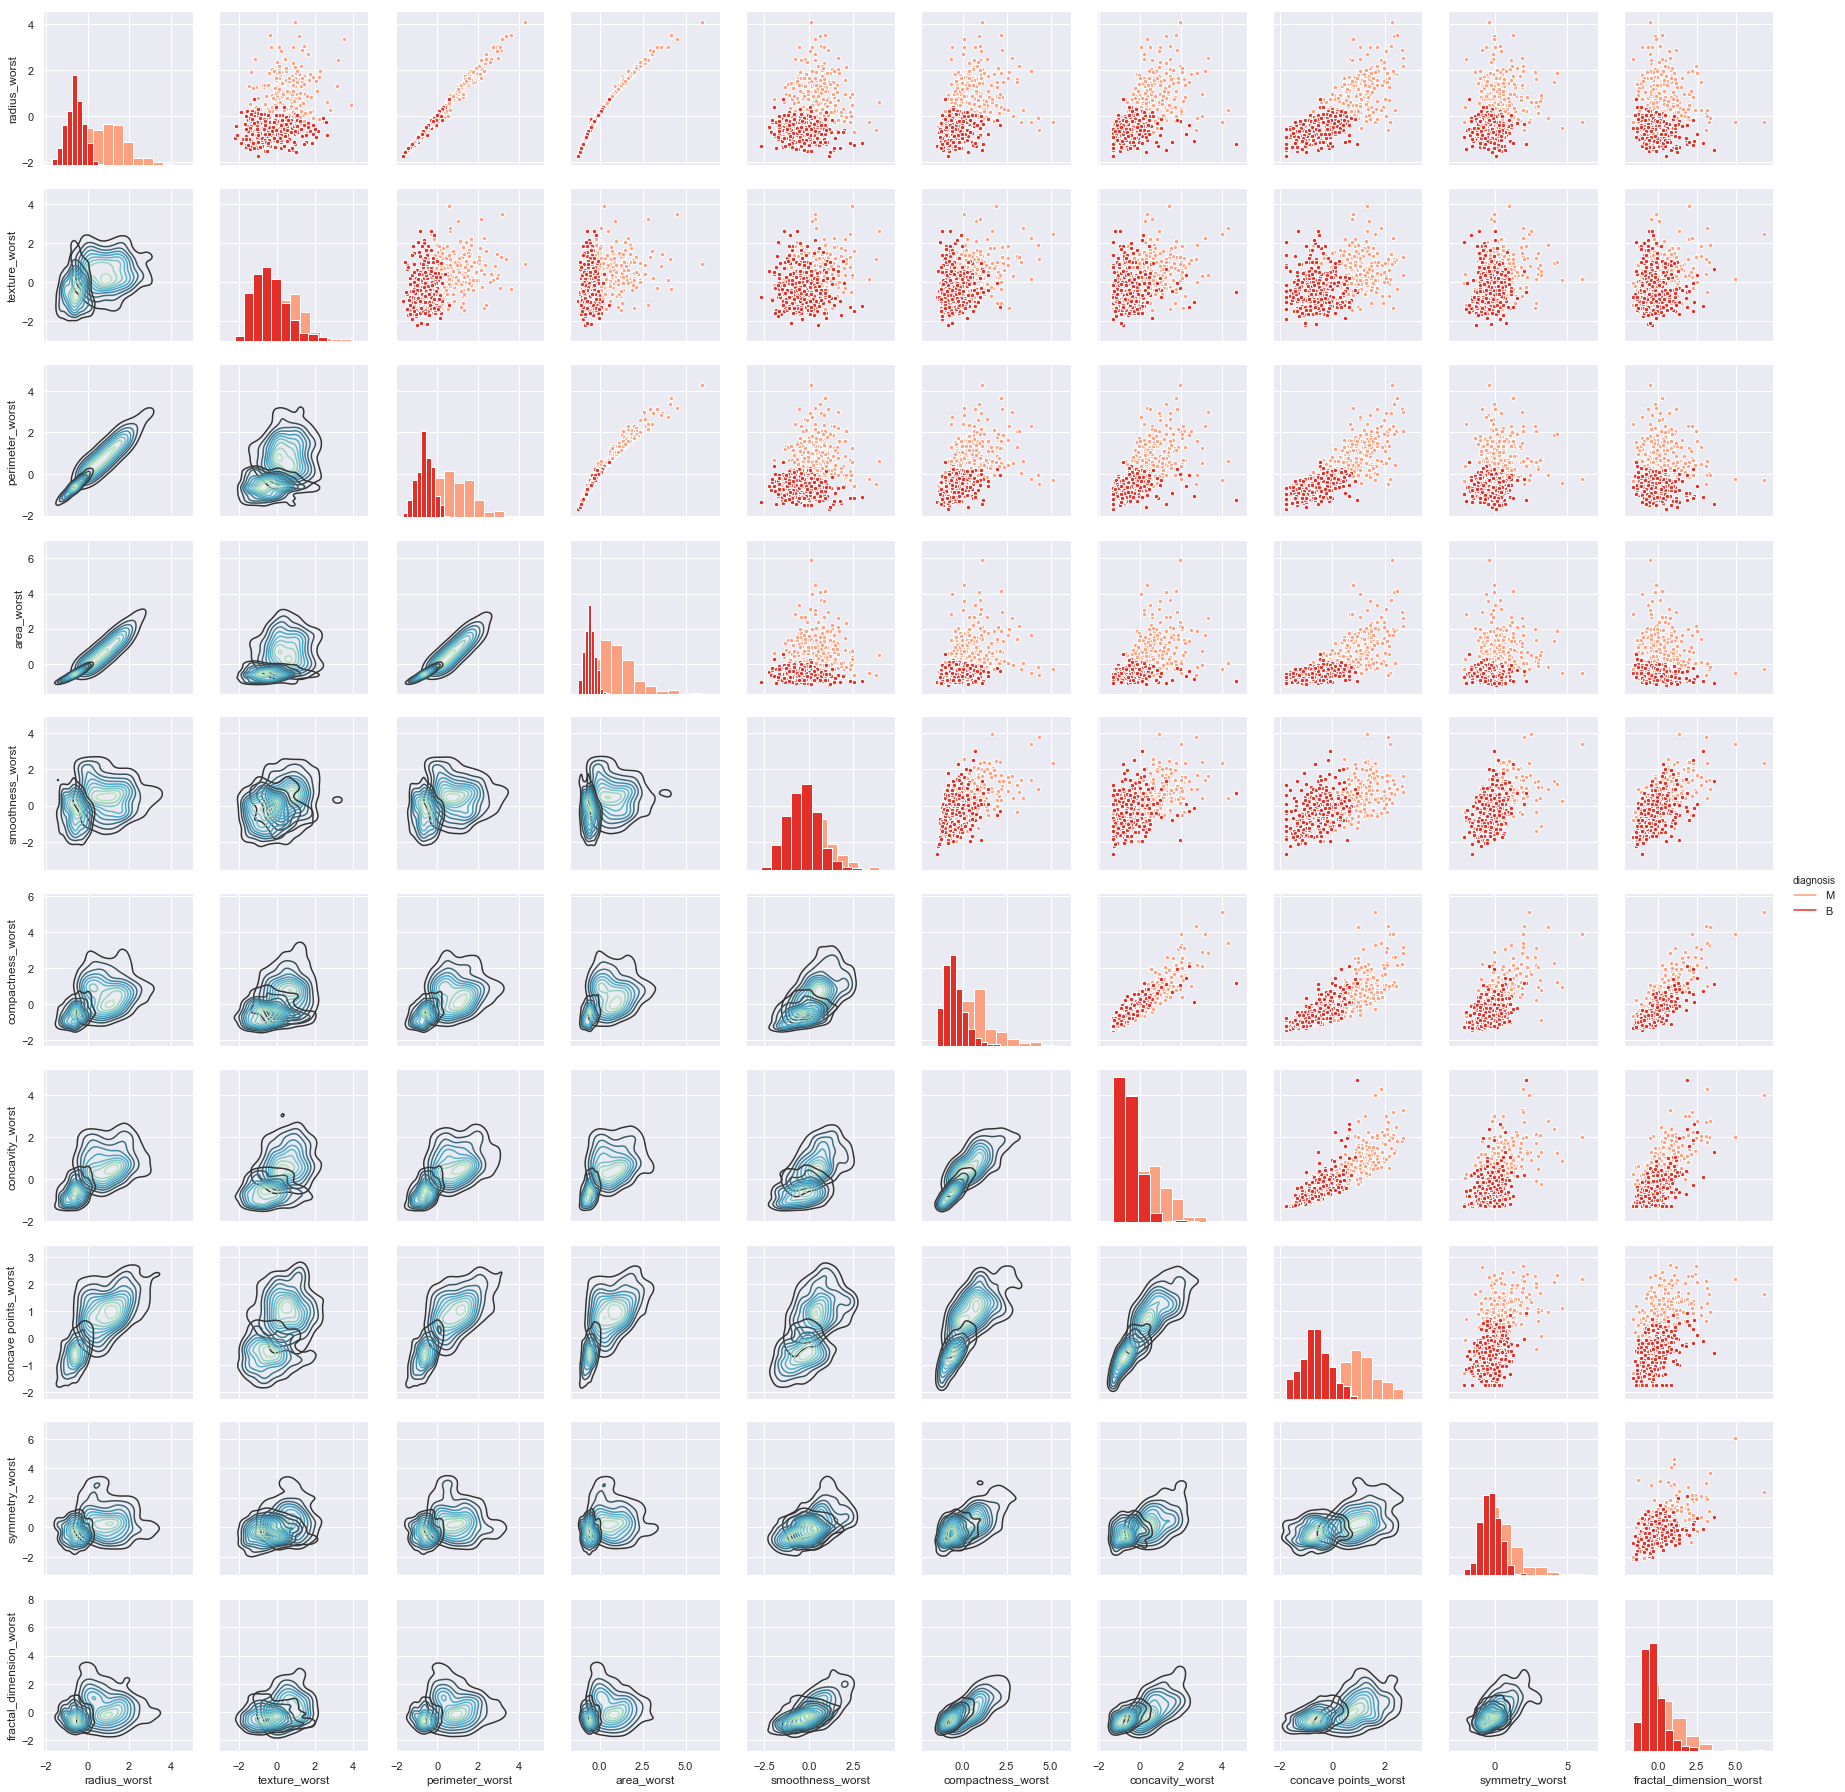

In [5]:
from pandas.tools.plotting import scatter_matrix
p = sns.PairGrid(bcs.iloc[:,20:32], hue = 'diagnosis', palette = 'Reds')
p.map_upper(plt.scatter, s = 20, edgecolor = 'w')
p.map_diag(plt.hist)
p.map_lower(sns.kdeplot, cmap = 'GnBu_d')
p.add_legend()

p.figsize = (30,30)

lets see how each variable breaks down by diagnosis

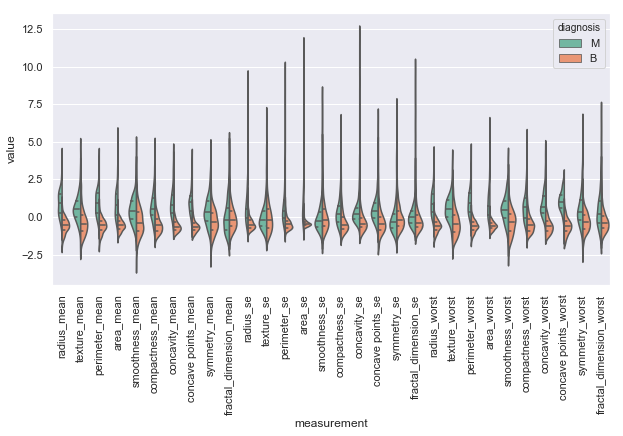

In [6]:
mbc = pd.melt(bcs, "diagnosis", var_name="measurement")
fig, ax = plt.subplots(figsize=(10,5))
p = sns.violinplot(ax = ax, x="measurement", y="value", hue="diagnosis", split = True, data=mbc, inner = 'quartile', palette = 'Set2');
p.set_xticklabels(rotation = 90, labels = list(bcs.columns));

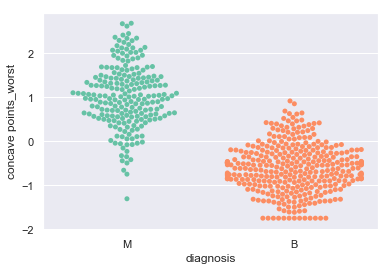

In [7]:
sns.swarmplot(x = 'diagnosis', y = 'concave points_worst',palette = 'Set2', data = bcs);


C:\Users\Admin\Anaconda3\New folder (2)\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\Anaconda3\New folder (2)\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


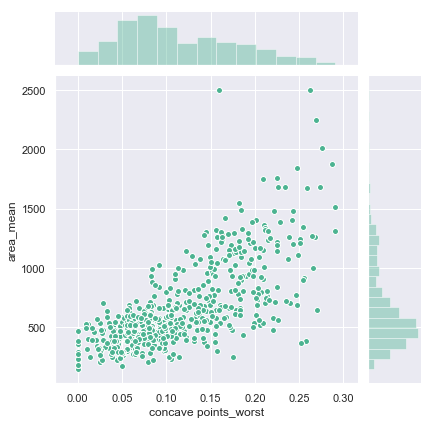

In [8]:
sns.jointplot(x = bc['concave points_worst'], y = bc['area_mean'], stat_func=None, color="#4CB391", edgecolor = 'w', size = 6);

let's bulid a SVM to predict malignant or benign tumors

In [9]:
X = bcs.ix[:,0:30]

y = bcs['diagnosis']
class_names = list(y.unique())
X

C:\Users\Admin\Anaconda3\New folder (2)\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
5,-0.476375,-0.835335,-0.387148,-0.505650,2.237421,1.244335,0.866302,0.824656,1.005402,1.890005,...,-0.165498,-0.313836,-0.115009,-0.244320,2.048513,1.721616,1.263243,0.905888,1.754069,2.241802
6,1.170908,0.160649,1.138125,1.095295,-0.123136,0.088295,0.300072,0.646935,-0.064325,-0.762332,...,1.368983,0.322883,1.368325,1.275220,0.518640,0.021215,0.509552,1.196716,0.262476,-0.014730
7,-0.118517,0.358450,-0.072867,-0.218965,1.604049,1.140102,0.061026,0.281950,1.403355,1.660353,...,0.163763,0.401048,0.099449,0.028859,1.447961,0.724786,-0.021054,0.624196,0.477640,1.726435
8,-0.320167,0.588830,-0.184080,-0.384207,2.201839,1.684010,1.219096,1.150692,1.965600,1.572462,...,-0.161357,0.822813,-0.031609,-0.248363,1.662757,1.818310,1.280035,1.391616,2.389857,1.288650
9,-0.473535,1.105439,-0.329482,-0.509063,1.582699,2.563358,1.738872,0.941760,0.797298,2.783096,...,-0.244190,2.443109,-0.286278,-0.297409,2.320295,5.112877,3.995433,1.620015,2.370444,6.846856


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Model scores very well. very slight over-fitting.

In [11]:
svc = SVC(kernel = 'linear',C=.1, gamma=10, probability = True)
svc.fit(X,y)
y_pred = svc.fit(X_train, y_train).predict(X_test)
t = pd.DataFrame(svc.predict_proba(X_test))
svc.score(X_train,y_train), svc.score(X_test, y_test)


(0.984251968503937, 0.9787234042553191)

Confusion matrix, without normalization
[[119   2]
 [  2  65]]
Normalized confusion matrix
[[0.98 0.02]
 [0.03 0.97]]


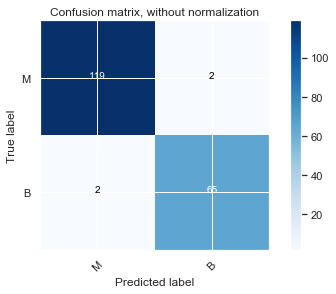

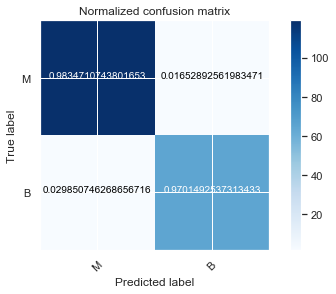

In [12]:
mtrx = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(mtrx,classes=class_names,title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(mtrx, classes=class_names, normalize = True, title='Normalized confusion matrix')

plt.show()
